<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/YOLO9000_Better%2C_Faster%2C_Stronger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YOLO9000: Better, Faster, Stronger**

논문 링크: https://arxiv.org/abs/1612.08242

본 논문에서는 YOLO v2와 YOLO9000를 제안한다. 이때, YOLO v2는 YOLO v1을 개선한 버전이며 YOLO9000은 9000개의 카테고리를 탐지할 수 있도록 설계된 NN이다.(YOLO9000은 ImageNet dataset과 COCO dataset을 동시에 학습하였다.)

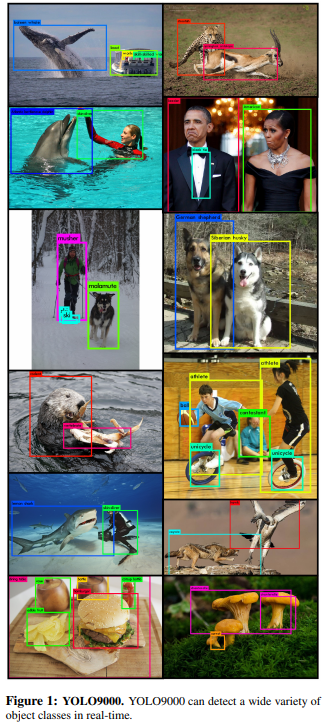

위의 그림 Figure 1에서는 YOLO9000의 결과물을 보여준다.

## **YOLO v2 구조**

먼저, YOLO v2가 기존 YOLO v1에서 무엇이 개선되었는지를 알아보겠다.

### **Better**

YOLO v1의 단점으로는 타 object detection model들에 비해 bbox 위치를 제대로 포착하지 못하는 **localization error**가 많으며, region proposal-based 방법보다 **recall**이 낮다.

따라서 본 논문의 저자는 localization과 recall을 개선시키는 것에 포커스를 맞췄다. 보통 더 나은 성능을 얻기 위해선 앙상블이나 model의 크기를 늘리는 방법을 이용하지만, YOLO는 빠른 속도가 핵심이기 때문에 다른 방법들을 사용하였다.

#### **Batch Normalization**

첫 번째로 YOLO의 convolution layer에 dropout을 대신해 BN을 이용했다. 이를 통해 mAP를 2% 정도 상승시켰다.

#### **High Resolution Classifier**

YOLO v1에서는 VGG-16을 기반으로 하였기 때문에 input imaze의 size를 224 x 224로 train을 진행시켰다. 하지만, detection에서는 input isze를 448 x 448을 이용하기 때문에 성능이 떨어질 수 밖에 없다.

따라서 이를 위해 YOLO v2는 ImageNet dataset에서 448 x 448 image로 fine-tuning을 해주고, detection을 위한 fine-tuning도 해주어 mAP를 4% 정도 상승시켰다.

#### **Convolutional With Anchor Boxes**

YOLO v2에서는 YOLO v1의 fc layer를 제거하고 **anchor box**를 활용해 bounding box를 구한다. 1 x 1 convolution layer로 예측을 한다는 뜻이다.

bbox box의 좌표를 예측하는 것보단 사전에 정의한 Anchor box에서 offset을 예측하는 것이 훨씬 간단하게 train할 수 있기 때문이다. 이를 위해 본 논문에서는 하나의 pooling layer를 제거함으로써 convolution layer의 출력을 high-resolution으로 만들어주었고, input image size를 448에서 416으로 변경하였다. 416을 32배로 down-sampling하면 13 x 13 feature map이 얻어지며, 448을 32배로 down-sampling하면 14 x 14 feature map이 얻어진다.

13 x 13 feature map이 더 좋은 이유는 보통 object가 중앙에 있는 경우가 많기 때문에, 최종 output feature map을 홀수 x 홀수로 지정하는 것이 좋다고 한다. 짝수로 지정할 경우, 중앙에 4개의 grid cell이 인접하기 때문이다.

anchor box를 이용시 mAP는 감소, recall은 증가한다. 이용하지 않을시 mAP는 69.5, recall은 81%이며 이용시 mAP는 69.2, recall은 88%이다.

#### **Dimension Clusters**

Anchor box를 도입하면 NN은 Anchor box를 수정하면서 bbox를 예측해야 한다. 따라서 사전에 설정된 anchor box의 영향이 클 수 밖에 없고 신중하게 anchor box를 선택해야 한다. 이를 위해 anchor box를 training set의 bbox에서 k-means clustering을 사용해 얻는다.

일반적인 k-means clustering은 Euclidean distance를 이요한다. 하지만, **YOLO v2에서는 Euclidean distance를 사용한 k-means clustering을 이용하면 문제가 발생**한다. 실제 bbox와 높은 IoU를 지닌 anchor box를 선정해야 하는데, 중심 좌표 거리가 가장 짧은 것을 기준으로 anchor box를 선정할 시, IoU가 낮은 anchor box를 선정할 수 있다는 것이다.

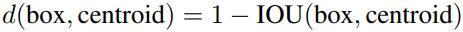

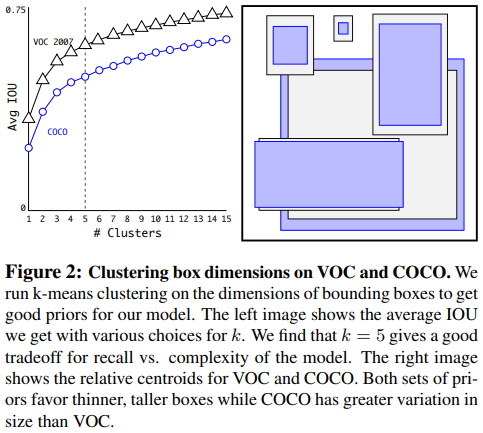

이를 위하여 위의 식과 같이 IoU를 기준으로 k-means clustering을 사용한다. hyper-parameter k의 경우 속도와 정확도의 밸런스를 고려하여 5로 선정하였다. 높은 k를 선택시 높은 정확도를 얻을 수 있지만, 속도가 느려지기 때문이다. 위의 그림 Figure 2는 k에 따른 평균 IoU이다.

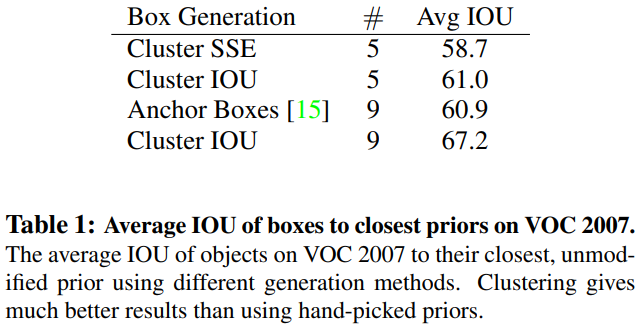

위의 표 Table 1을 보면 확실히 clustering 방법이 더 좋은 결과를 가져온다는 것을 알 수 있다.

#### **Direct location prediction**

하지만, anchor box를 활용한 bbox offset은 bbox의 위치를 제한하지 않기 때문에 초기 학습이 불안정하다는 단점이 있다. 따라서, 안정적으로 bbox를 예측하기 까지 오래걸린다.

이 문제를 해결하기 위하여 sigmoid를 활용해 offset의 범위를 [0,1]로 제한하였다.

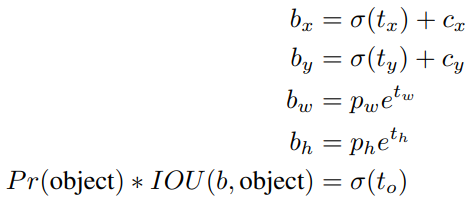

model은 각 bbox마다 (t_x, t_y, t_w, t_h, t_o)를 예측한다. 수식은 위와 같다. 이때, c_x와 c_y는 각각 좌측 상단에서 grid cell의 x좌표와 y좌표이며, p_w와 p_h는 각각 이전 bbox의 너비와 높이이다.

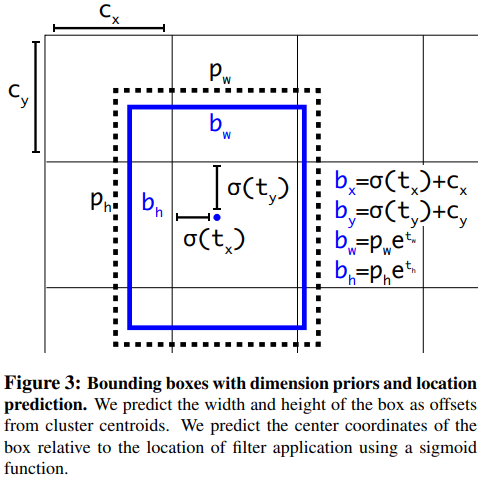

위의 그림 Figure 3과 같이 bbox의 중심 좌표 예측값인 (t_x, t_y)를 sigmoid 함수로 감싸 bbox의 위치를 제한하였기 때문에 안정적으로 train이 가능하다.

이 방법과 clustering을 활용해 성능이 5% 가량 향상됬다.

#### **Fine-Grained Features**

YOLO v2는 13 x 13 feature map을 출력한다. 이는 큰 object를 검출할 때는 충분하지만, 작은 object를 검출하기에는 불충분하다.

Faster R-CNN과 SSD는 다양한 size의 feature map에서 영역을 제안하여 이를 해결한다.

YOLO v2의 경우에는 passthrough layer를 추가하여 이전 layer의 26 x 26 feature map을 가져온 후 13 x 13 feature map에 이어 붙인다. 물론 feature map의 크기가 다르므로 26 x 26 x 512를 13 x 13 x (512 x 4)로 만들어 이어붙인다.

이 방법을 통해 성능을 1%가량 향상시켰다.

#### **Multi-Scale Training**

YOLO v2는 다른 size의 image로부터 robust를 갖기 위해 다양한 size로 train을 진행한다. 매 10epoch마다 {320, 352, ..., 608}로 학습을 진행한다. 간격이 32인 이유는 YOLO v2가 input size의 32배 down-sampling을 하기 때문에 간격을 32로 지정한 것이다.

또한, 이것으로 속도와 정확도 trade-off를 조절할 수 있다. 크기를 키우면 더 정확하지만 느리며, 크기를 줄이면 덜 정확하지만 빠르다.

### **Faster**

Faster 파트에서는 YOLO v2에서 사용하는 Darknet-19를 소개한다. 많은 detection 방법들이 VGG-16를 사용하는데, VGG-16은 좋은 성능을 보여주지만 연산량이 많다. 따라서 빠른 속도를 지향하는 YOLO v2에서는 새로운 NN인 Darknet-19를 구축해 이용한다.

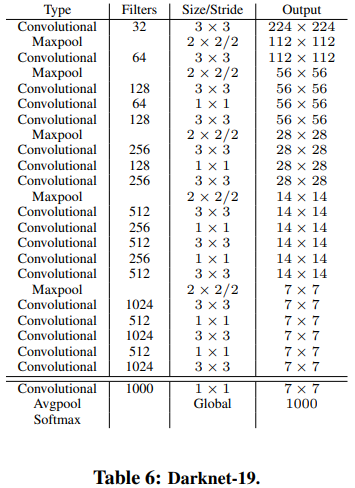

Darknet-19의 구조는 위의 표 Table 6에서 보여준다. VGG model에서 사용하는 3 x 3 filter와 GoogLeNet에서 상ㅇ하는 NIN(Network in Network) 기법을 사용한다. 또한, FC layer까지 제거함으로써 연산량을 줄였다.

### **Stronger**

Stronger 파트에서는 YOLO9000을 소개한다. 맨 처음에 언급했듯이 YOLO9000은 classificaition dataset과 object detection dataset을 동시에 학습을 시켜 9000개의 카테고리를 탐지할 수 있도록 설계된 것이다.

detection data로 bbox와 objectness같은 정보를 학습하고 classification data로 class label을 학습해 카테고리 수를 확장한다.

하지만 이때, 몇 가지의 문제점이 발생하게 된다.

첫 번째로, detection label과 classification label이 다르다. detection dataset은 일반적으로 적은 범위의 label을 갖는다. 반대로 classifciation dataset은 넓은 범위의 label을 갖는다. 이 두 label을 병합하기 위한 일관성있는 방법이 필요하다.

두 번째로, 최종 class 확률을 계산할 시, 각 class가 상호 배타적(mutually exclusice)로 가정한다. 두 dataset을 결합하면 detection data label인 dog과 classificaiton data label인 Nortfolk terrier은 상호 배타적이지 않다. 따라서 multi-label model을 사용해 상호 배타를 가정하지 않았다.

#### **Hierarchical classification**

이를 해결하기 위해 먼저 ImageNet의 label 구조에 대해 알아야 한다. ImageNet의 label은 WordNet의 구조에 따라 정리되어 있다. WordNet은 tree가 아니라 우향 그래프(directed graph)로 구현이 되어 있는데, YOLO v2에서는 graph 구조 대신 tree 구조를 구축해 사용한다.

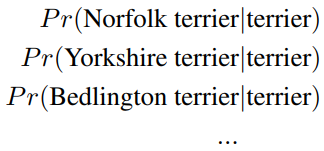

terrier를 예시로 하자면 위와 같이 된다.

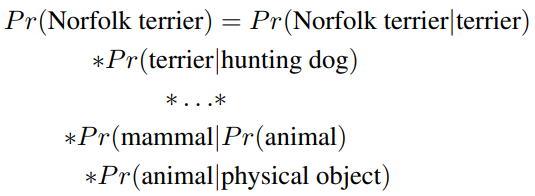

특정 노드에서 확률을 구하고 싶을 때는 tree의 경로를 따라서 모든 노드의 조건부 확률을 곱한다. Norfolk terrier을 예시로 들면 위와 같다.

ImaeNet에서 1000개의 class를 사용해 구축한 wordtree로 Darknet-19를 train한다. 중간에 노드를 추가해 label은 총 1369개로 확장이 되었다. train 과정에서 실제 label을 tree의 루트까지 전파한다. 따라서 image가 Norfolk terrier를 갖고 있으면, dog과 mammal label도 얻게 된다.

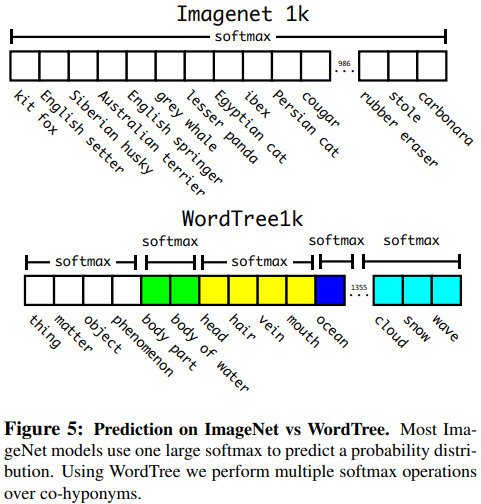

조건부 확률을 계산하기 위해 1369개의 벡터를 예측하고, 모든 같은 개념의 하의어를 갖는 관련어에 대한 softmax를 계산한다. 단순하게 하나의 softmax를 계산하는 것이 아니라 위의 그림 Figure 5와 같이 동의어에 대한 폭이 다양한 여러 개의 softmax를 계산한다.

이 방법은 성능이 하락하지만, dog image를 보여줄 때, 가장 높은 confidence로 dog을 예측하고, 낮은 confidence로 하의어를 예측한다. detection을 수행시 bbox를 예측하고 확률의 tree를 얻는다. 이 tree를 따라 내려가다 높은 confidence를 지닌 경로를 선택한다. 임계점에 도달할 때까지 반복하여 해당 class를 예측한다.

#### **Dataset combination with WordTree**

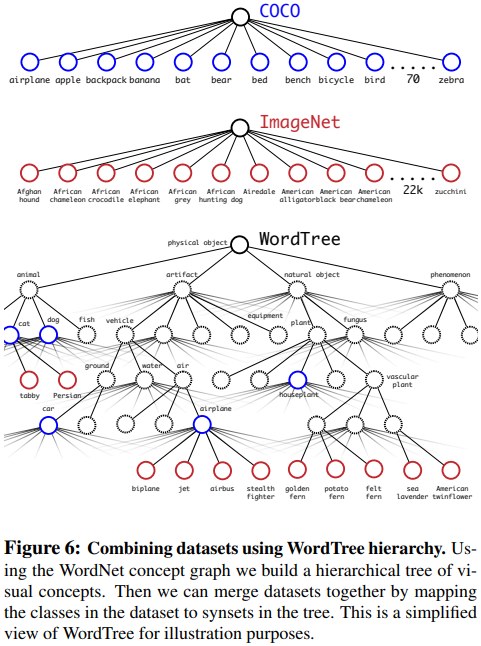

COCO dataset과 ImageNet dataset을 결합하기 위해 WordTree를 사용했다. dataset에 있는 범주와 tree에 있는 관련어를 간단하게 연결한 것의 예시가 위의 그림 Figure 6이다.

#### **Joint classification and detection**

이제 WordTree로 model을 train 시키는데, 총 9418개의 clss를 WordTree에서 ImageNet이 COCO보다 data가 훨씬 많기 때문에 4:1 비율로 oversampling을 한다. 또한, output size의 한계 때문에 5개가 아닌 3개의 prior을 사용해 YOLO9000을 train한다.

detection image를 보면 평소대로 loss를 계산하고 classification loss는 해당 class와 그것의 상위 class에 대해서만 역전파를 진행한다.

## **Experiments**

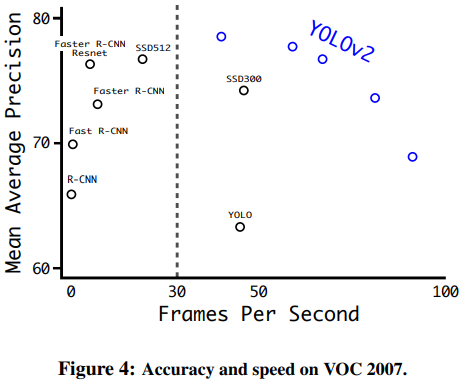

위의 그림 Figure 4에서는 YOLO v2가 VOC 2007 dataset에 대해 얼마나 빠른 속도와 정확도를 가지는지 보여준다.

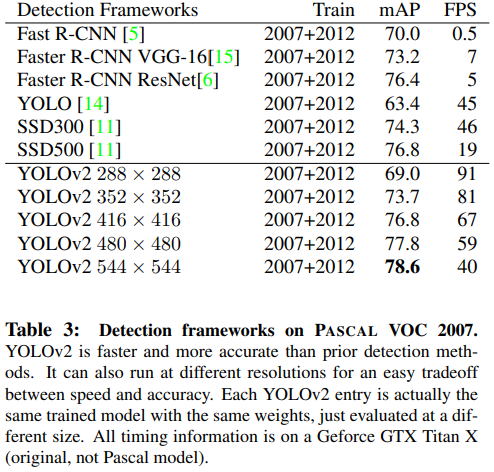

위의 표 Talbe 3에서도 마찬가지로 YOLO v2의 성능을 보여준다. 이때 size에 따른 성능을 보여주는데, 위에서 언급했듯이 size가 크면 정확도는 비례하지만, 속도는 반비례한다는 것을 알 수 있다.

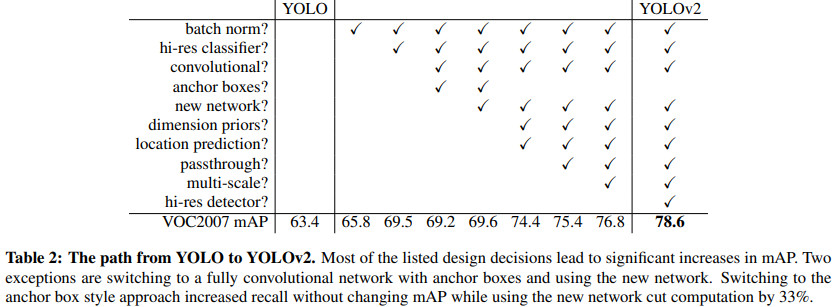

위의 표 Table 2는 위에서 설명했던 것들을 YOLO v1에 다 적용해 YOLO v2로 만드는 것을 표로 보여준다.

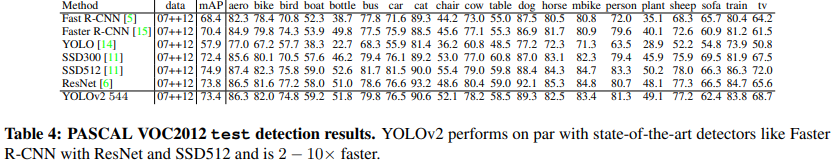

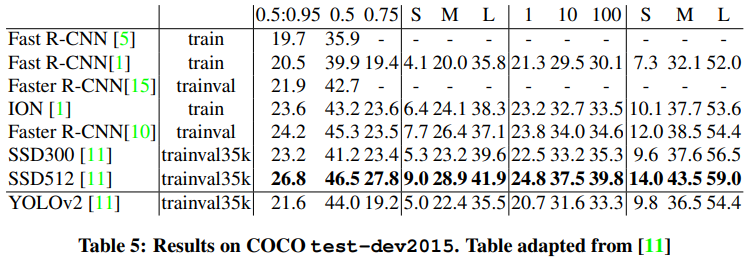

위의 표들 Table 4와 5에서도 마찬가지로 YOLO v2의 성능을 보여준다.